# Multi-cell geolift analysis

In other examples, we've seen how we can use Synthetic Control methods to estimate the causal impact of a treatment in one geographic area (geo). In this example, we'll extend the analysis to multiple geographic areas (geos).

This may be a particularly common use case in marketing, where a company may want to understand the impact of a marketing campaign in multiple regions. But these methods are not restricted to marketing of course - the methods shown here are general. Another concrete use case may be in public health, where a public health intervention may be rolled out in multiple regions.

This notebook focusses on the situation where the treatment has already taken place, and now we want to understand the causal effects of the treatments that were executed. Much work likely preceded this analysis, such as asking yourself questions like "which geos should I run the treatment in?", "what should the treatment be?" But these pre-treatment questions are not the focus of this notebook.

We can imagine two scenarios (there may be more), and show how we can tailor our analysis to each:

1. The treatments were similar in kind and/or magnitude in each region. An example of this may be where a company ran the same marketing campaign in multiple test geos. In cases like this, we can imagine that the causal impact of the treatment may be similar in each region. So we will show an example of how to analyse geo lift data like this. **We can think of this as a fully pooled analysis approach.**

2. The treatments were of different kinds and/or magnitudes in each region. An example of this may be where different marketing campaigns were run in different regions, and perhaps the budgets were different in each region. In cases like this, we can imagine that the causal impact of the treatment may be different in each region. So we will show an example of how to analyse geo lift data like this. **We can think of this as as an unpooled analysis approach.**

Let's start with some notebook setup:

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

import causalpy as cp

In [2]:
seed = 42

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
pd.set_option("display.precision", 2)

## Load the dataset

:::{admonition} Developer notes
:class: dropdown
The synthetic dataset can be generated with the following code:

```python
from causalpy.data.simulate_data import generate_multicell_geolift_data


df = generate_multicell_geolift_data()
df.to_csv("../../../causalpy/data/geolift_multi_cell.csv", index=True)
```
:::

In [4]:
df = (
    cp.load_data("geolift_multi_cell")
    .assign(time=lambda x: pd.to_datetime(x["time"]))
    .set_index("time")
)

treatment_time = pd.to_datetime("2022-01-01")

# Define the treatment and control geos (the column names)
untreated = [
    "u1",
    "u2",
    "u3",
    "u4",
    "u5",
    "u6",
    "u7",
    "u8",
    "u9",
    "u10",
    "u11",
    "u12",
]

treated = ["t1", "t2", "t3", "t4"]

df.head()

,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,t1,t2,t3,t4
time,,,,,,,,,,,,,,,,
2019-01-06,5.06,2.97,2.96,2.37,1.00,2.87,1.90,1.03,4.16,2.06,3.85,2.80,3.02,2.65,3.01,2.36
2019-01-13,5.14,3.06,2.89,2.40,0.92,3.16,1.85,0.83,4.12,1.93,3.83,2.89,2.91,2.44,3.15,2.14
2019-01-20,5.09,3.20,2.84,2.43,0.97,3.18,1.80,1.15,4.08,2.14,3.82,2.92,3.00,2.50,3.09,2.32
2019-01-27,5.21,3.18,2.90,2.14,0.75,3.14,1.97,1.09,4.10,2.11,3.87,2.81,3.02,2.50,3.12,2.20
2019-02-03,4.86,3.14,2.81,2.31,0.61,3.36,2.00,1.13,4.21,2.03,3.87,2.97,2.98,2.41,3.07,2.25


Always visualise the data before starting the analysis. Our rather uncreative naming scheme uses `u` to represent untreated geos, and `t` to represent treated geos. The number after the `u` or `t` represents the geo number.

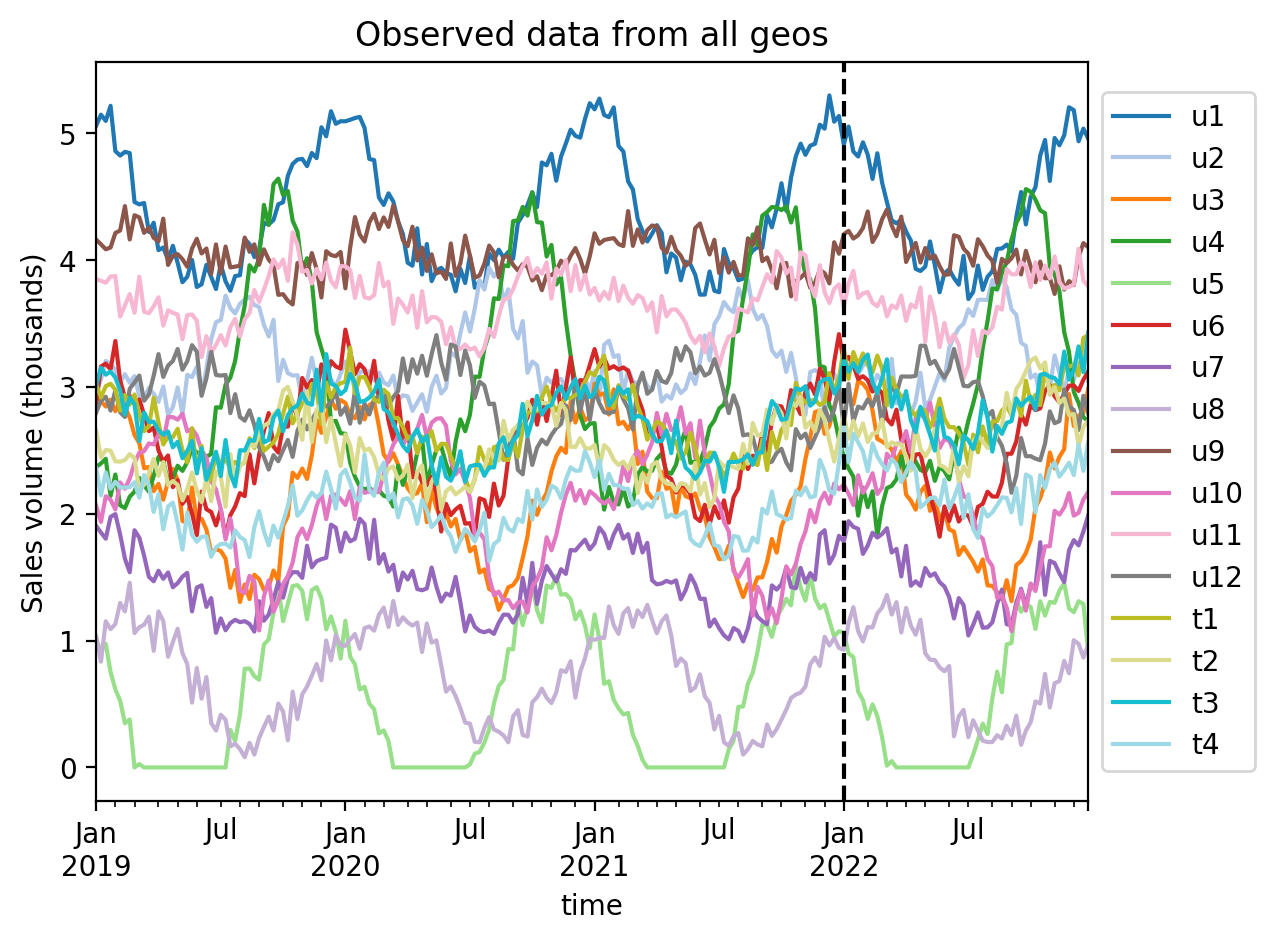

In [5]:
ax = df.plot(colormap="tab20")
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Observed data from all geos", ylabel="Sales volume (thousands)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

We can see that each geo has some seasonality component as well as some noise. The treatment (vertical dashed line) is the same in each geo. The question is: to what extent did we get uplift in our KPI in each treated geo?

## Pooled analysis approach

The first analysis approach is to aggregate the treated geos and analyze them as a group. In the code cell below we will aggregate with the median function, but we can also use the mean. While these are likely to be the most often used aggregation functions, the user is free to use any other function appropriate for a given dataset.

In [6]:
df["treated_agg"] = df[treated].median(axis=1)
df.head()

,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,t1,t2,t3,t4,treated_agg
time,,,,,,,,,,,,,,,,,
2019-01-06,5.06,2.97,2.96,2.37,1.00,2.87,1.90,1.03,4.16,2.06,3.85,2.80,3.02,2.65,3.01,2.36,2.83
2019-01-13,5.14,3.06,2.89,2.40,0.92,3.16,1.85,0.83,4.12,1.93,3.83,2.89,2.91,2.44,3.15,2.14,2.68
2019-01-20,5.09,3.20,2.84,2.43,0.97,3.18,1.80,1.15,4.08,2.14,3.82,2.92,3.00,2.50,3.09,2.32,2.75
2019-01-27,5.21,3.18,2.90,2.14,0.75,3.14,1.97,1.09,4.10,2.11,3.87,2.81,3.02,2.50,3.12,2.20,2.76
2019-02-03,4.86,3.14,2.81,2.31,0.61,3.36,2.00,1.13,4.21,2.03,3.87,2.97,2.98,2.41,3.07,2.25,2.69


Let's visualise this aggregated geo and compare it to the individual treated geo's.

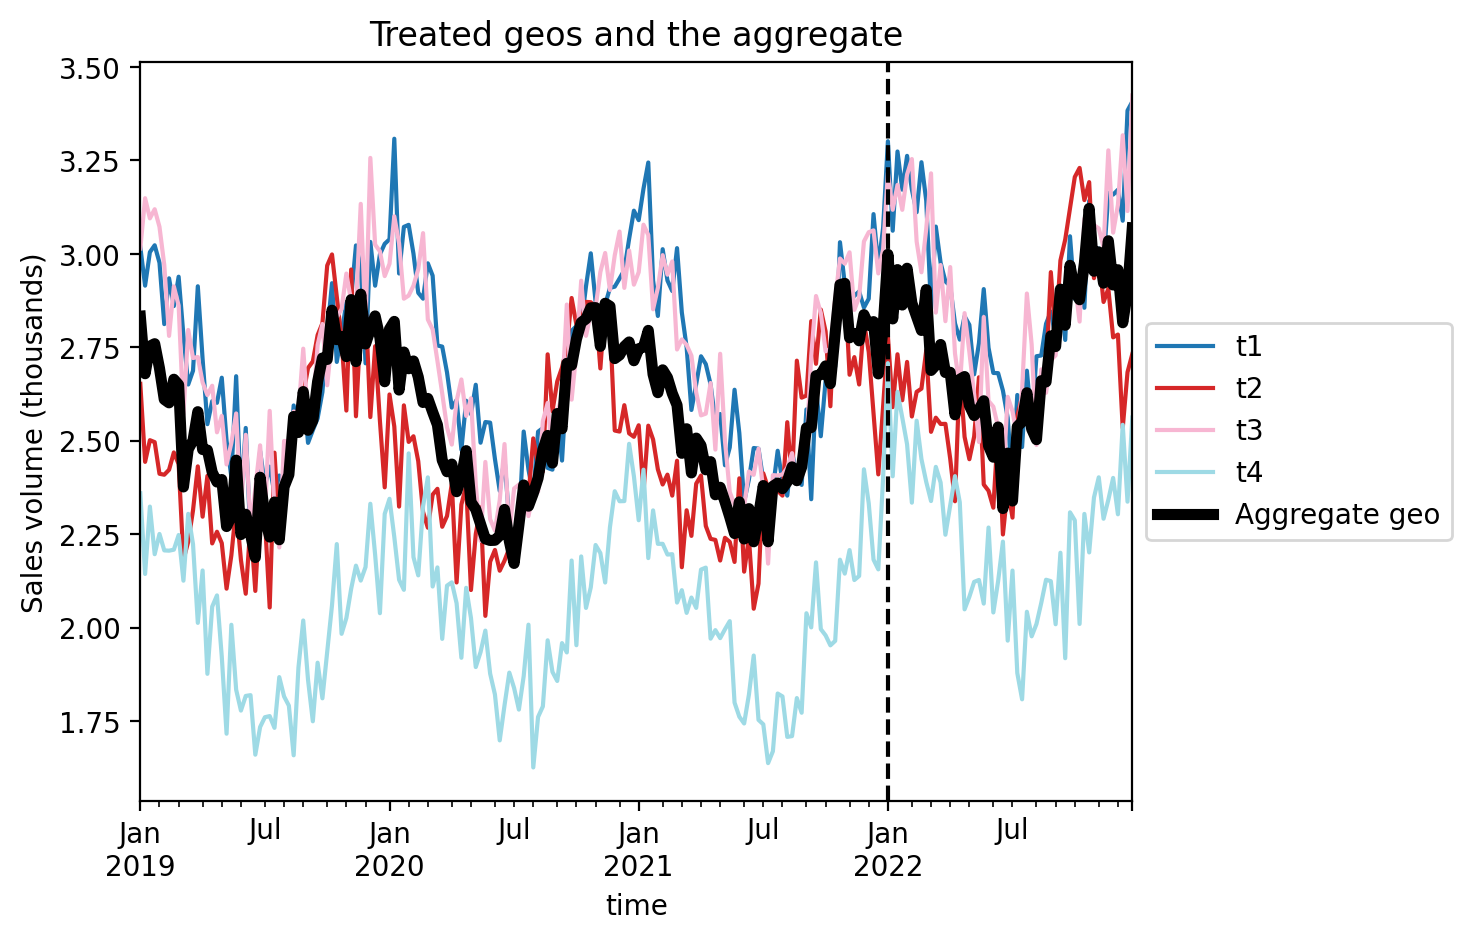

In [7]:
ax = df[treated].plot(colormap="tab20")
df["treated_agg"].plot(color="k", lw=4, ax=ax, label="Aggregate geo")
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Treated geos and the aggregate", ylabel="Sales volume (thousands)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5));

Now we just proceed as we would with a regular single-geo analysis.

Then we'll fit the model and print the summary.

In [8]:
pooled = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=untreated,
    treated_units=["treated_agg"],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [9]:
pooled.summary()

================================SyntheticControl================================
Control units: ['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 'u10', 'u11', 'u12']
Treated unit: treated_agg
Model coefficients:
    u1           0.13, 94% HDI [0.067, 0.18]
    u2           0.098, 94% HDI [0.053, 0.14]
    u3           0.094, 94% HDI [0.02, 0.17]
    u4           0.14, 94% HDI [0.099, 0.19]
    u5           0.069, 94% HDI [0.015, 0.13]
    u6           0.049, 94% HDI [0.0029, 0.12]
    u7           0.12, 94% HDI [0.032, 0.21]
    u8           0.11, 94% HDI [0.043, 0.17]
    u9           0.039, 94% HDI [0.0024, 0.1]
    u10          0.039, 94% HDI [0.0027, 0.087]
    u11          0.069, 94% HDI [0.0056, 0.15]
    u12          0.04, 94% HDI [0.0029, 0.099]
    y_hat_sigma  0.067, 94% HDI [0.06, 0.075]


We can see the model weightings visually like this:

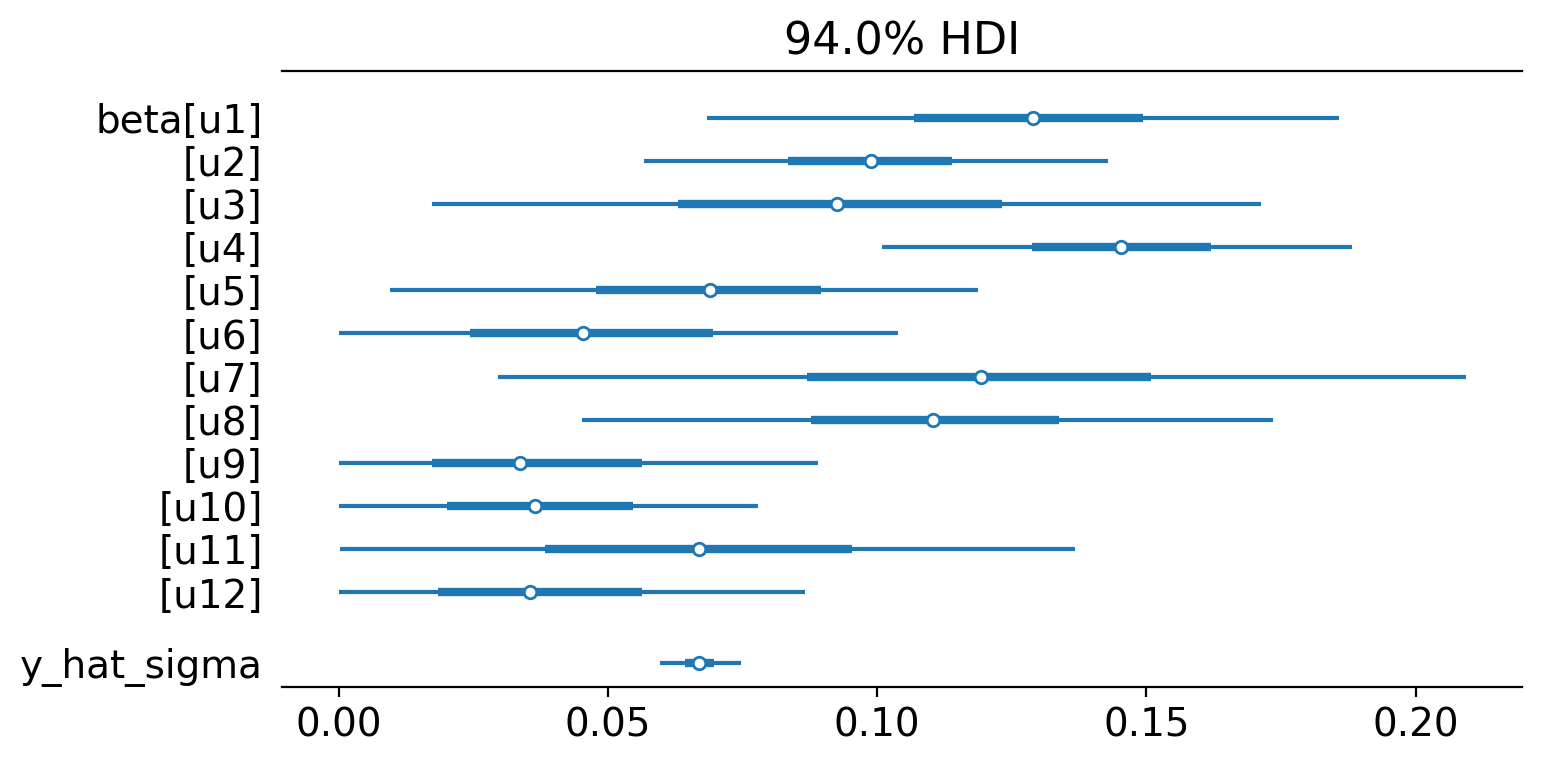

In [10]:
az.plot_forest(pooled.idata, var_names=["~mu"], figsize=(8, 4), combined=True);

And of course we can see the causal impact plot using the `plot` method.

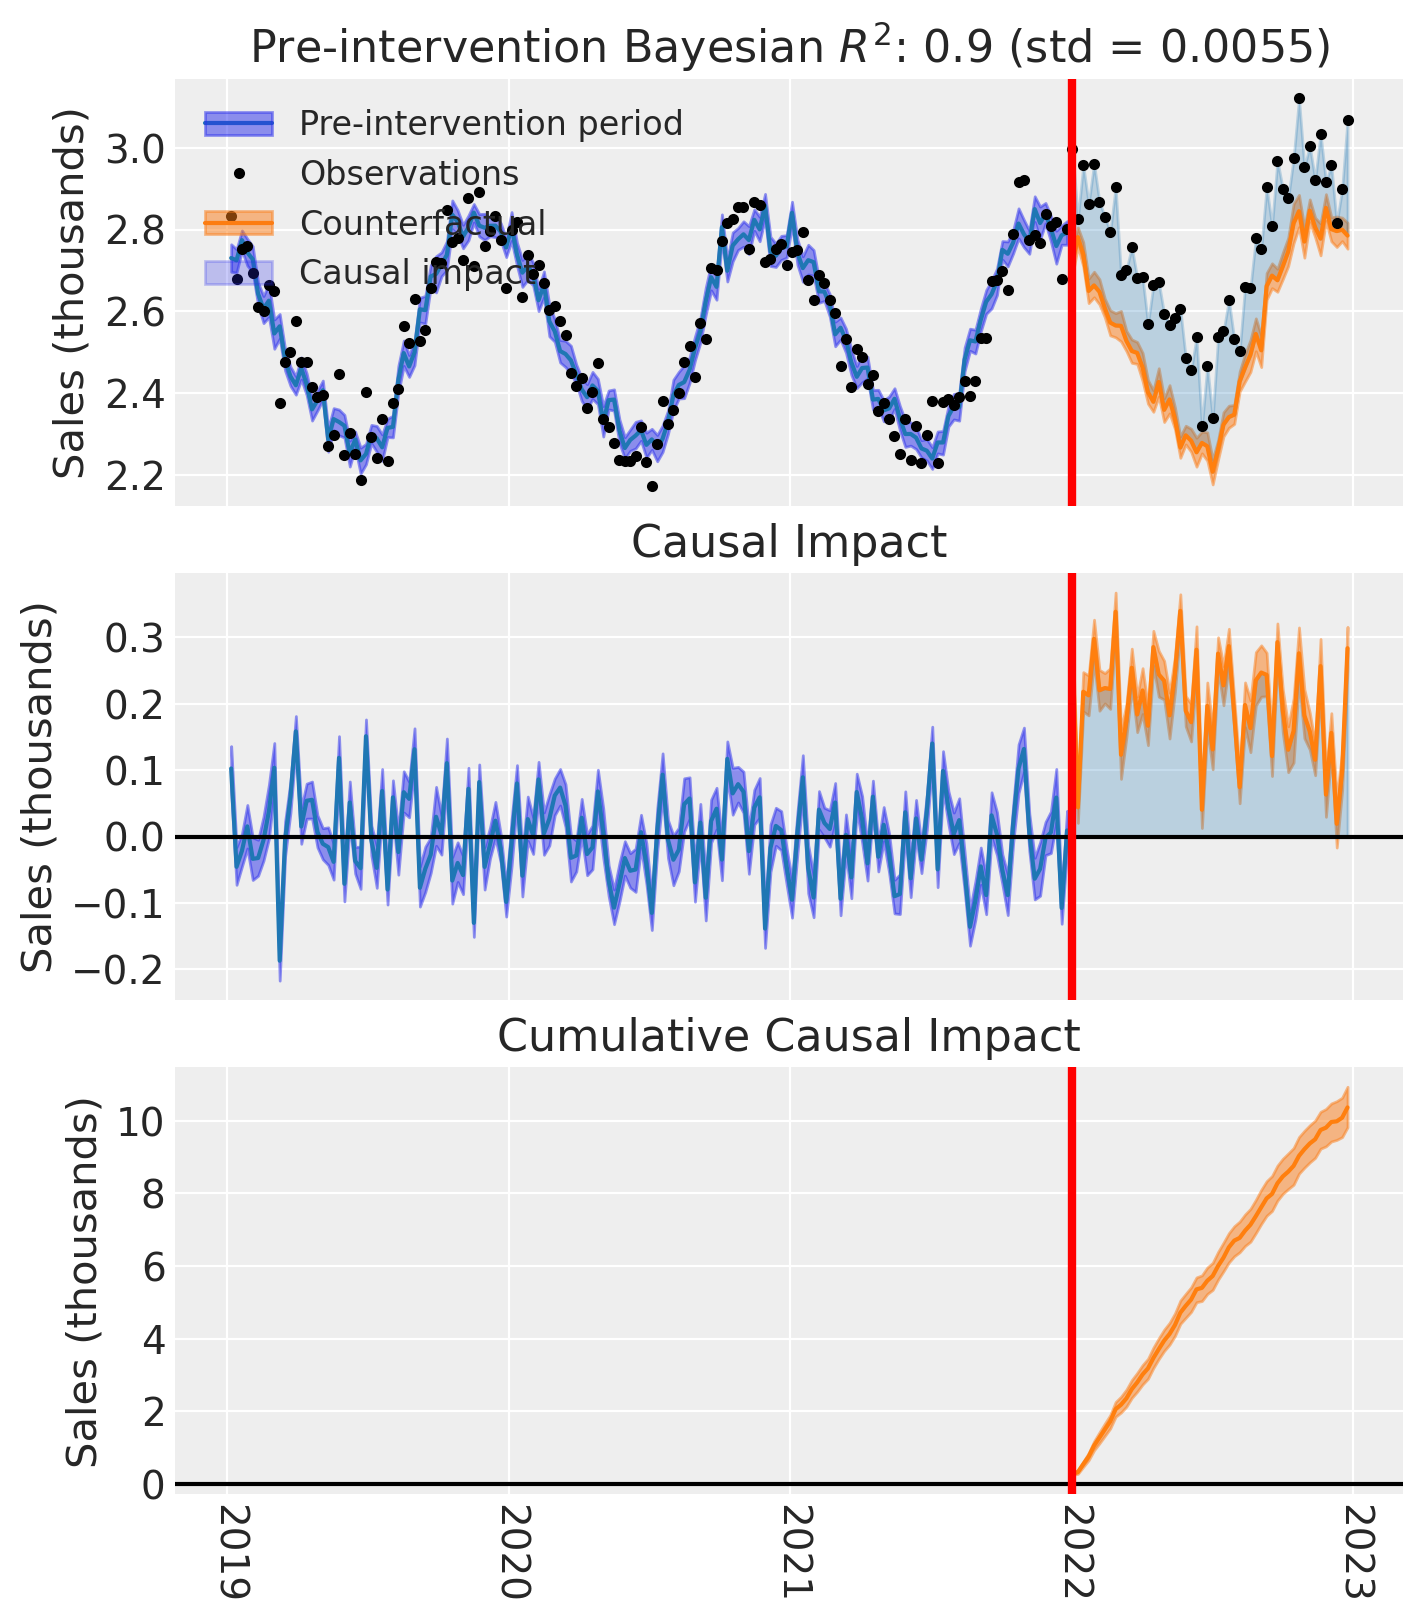

In [11]:
fig, ax = pooled.plot(plot_predictors=False, figsize=(15, 4))

# formatting
for i in [0, 1, 2]:
    ax[i].set(ylabel="Sales (thousands)")

## Unpooled analysis

The second analysis approach is to analyze each treated geo individually. We can do this in one shot by providing a list of treated geos to the `SyntheticControl` class.

In [12]:
treated

['t1', 't2', 't3', 't4']

In [13]:
untreated

['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 'u10', 'u11', 'u12']

In [14]:
result_unpooled = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=untreated,
    treated_units=treated,
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


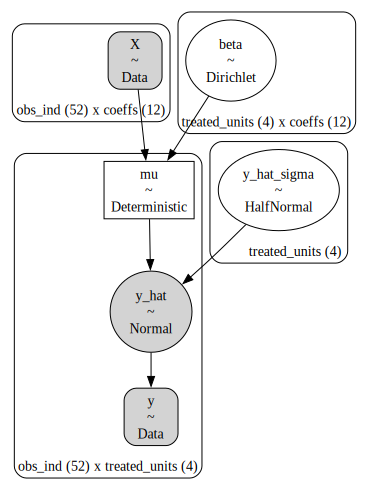

In [15]:
result_unpooled.model.to_graphviz()

We can get the summary of the posterior of the weighting coefficients (and the observation noise standard deviation) like this:

In [16]:
result_unpooled.summary()

================================SyntheticControl================================
Control units: ['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 'u10', 'u11', 'u12']
Treated units: ['t1', 't2', 't3', 't4']
Model coefficients:

Treated unit: t1
    u1           0.16, 94% HDI [0.082, 0.24]
    u2           0.059, 94% HDI [0.0072, 0.12]
    u3           0.1, 94% HDI [0.01, 0.21]
    u4           0.042, 94% HDI [0.0037, 0.084]
    u5           0.047, 94% HDI [0.0037, 0.11]
    u6           0.14, 94% HDI [0.038, 0.25]
    u7           0.11, 94% HDI [0.012, 0.23]
    u8           0.076, 94% HDI [0.0093, 0.16]
    u9           0.064, 94% HDI [0.0044, 0.15]
    u10          0.054, 94% HDI [0.0046, 0.12]
    u11          0.064, 94% HDI [0.004, 0.16]
    u12          0.074, 94% HDI [0.0056, 0.17]
    y_hat_sigma  0.1, 94% HDI [0.091, 0.11]

Treated unit: t2
    u1           0.054, 94% HDI [0.0052, 0.11]
    u2           0.13, 94% HDI [0.071, 0.18]
    u3           0.059, 94% HDI [0.0036, 0

We can also plot the weights of the untreated geos for each of the treated geos in a single plot. Each colour represents a different treated geo (see the legend).

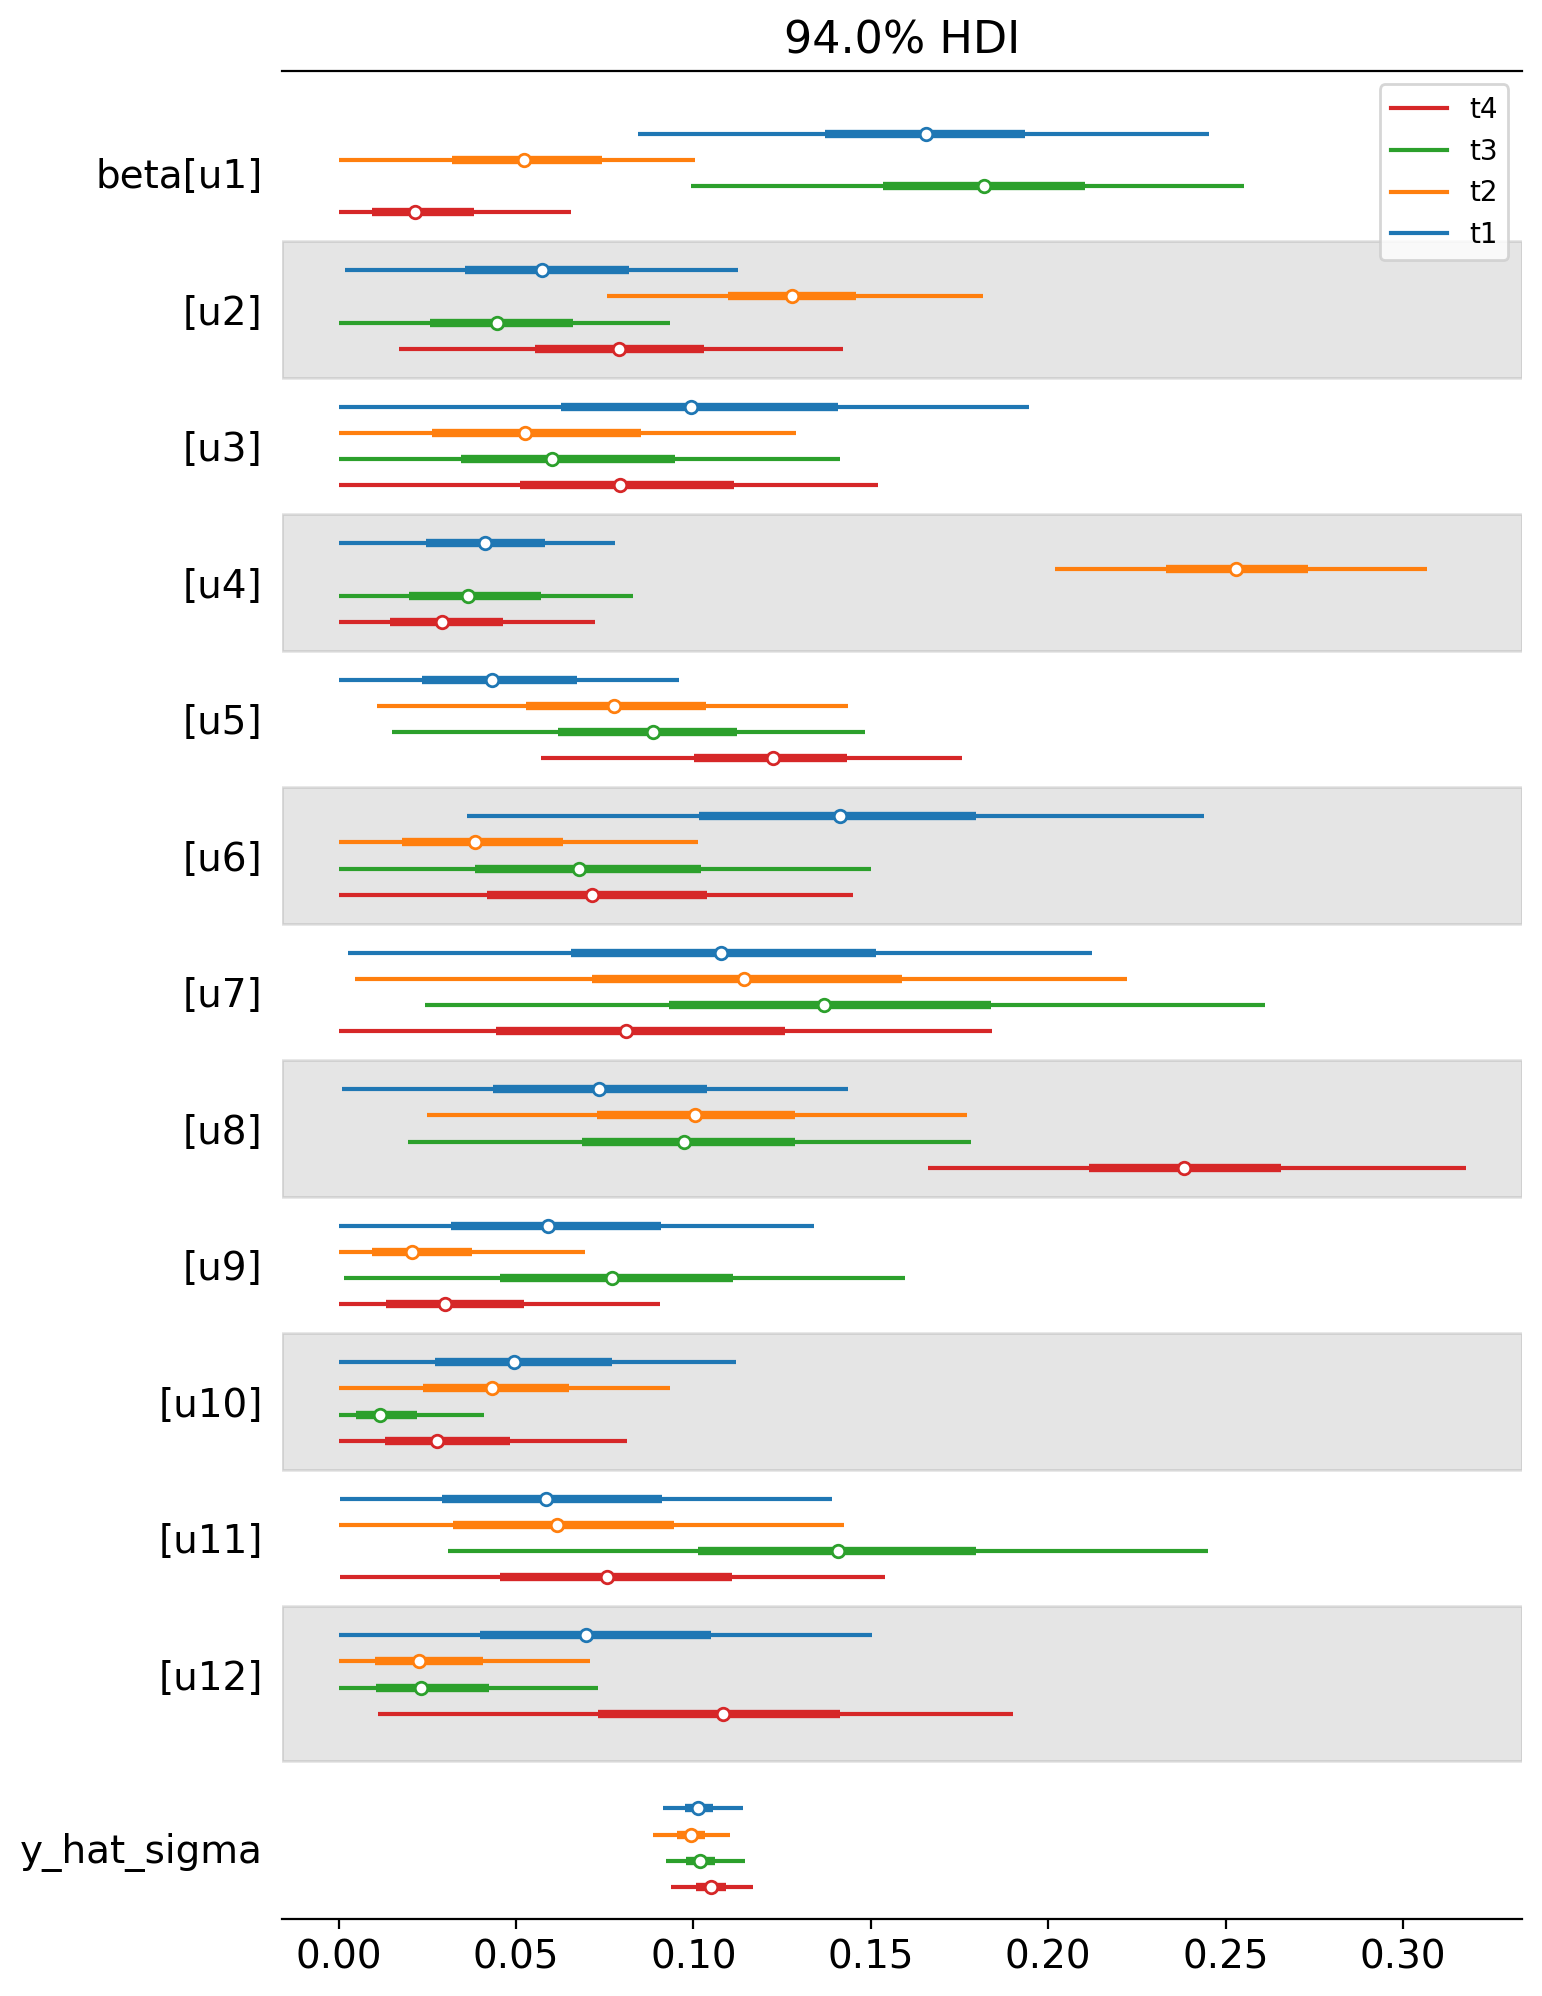

In [17]:
az.plot_forest(
    [
        result_unpooled.idata.posterior.sel(treated_units=treated_unit)
        for treated_unit in treated
    ],
    model_names=treated,
    var_names=["~mu"],
    combined=True,
    figsize=(8, 12),
);

And let's also plot the idiomatic causal impact plot for each treated geo.

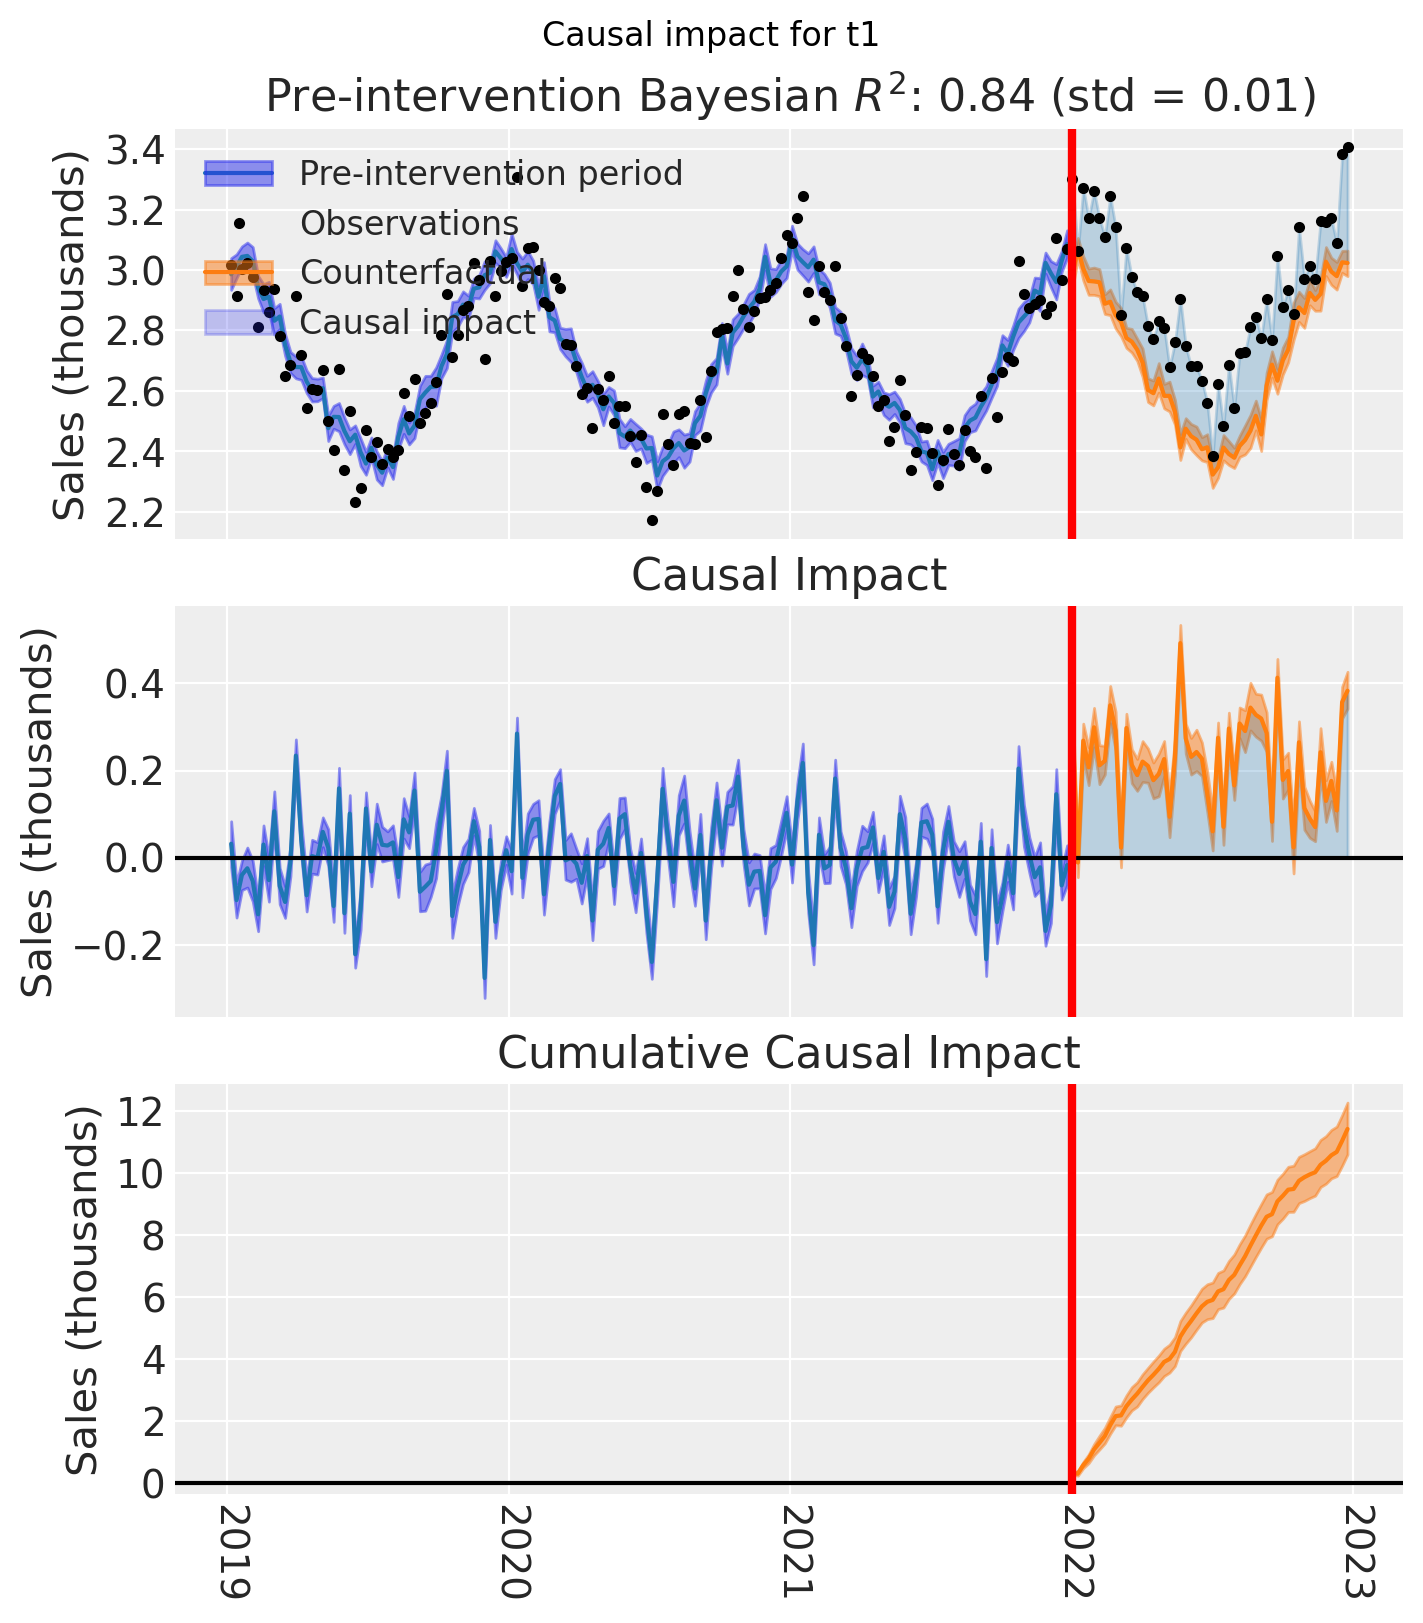

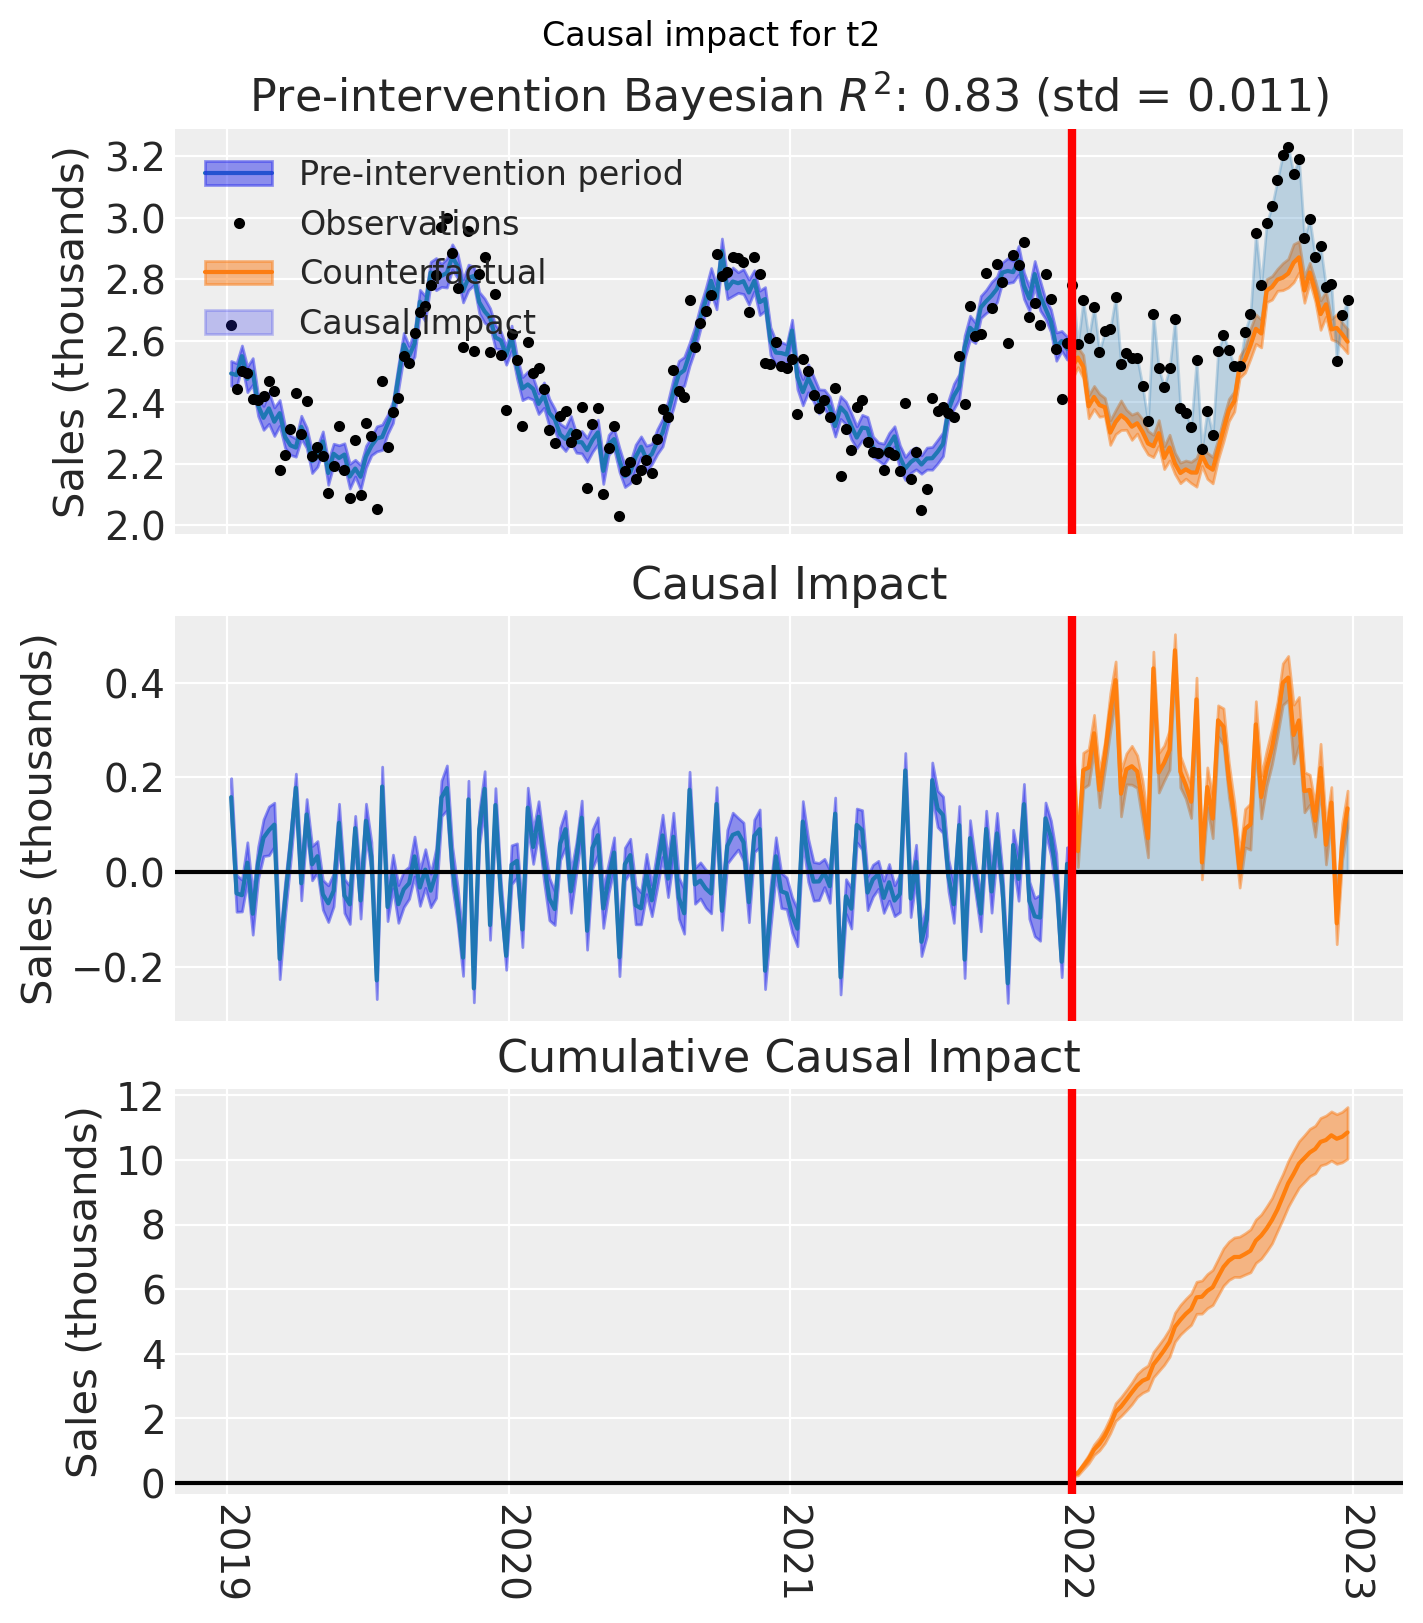

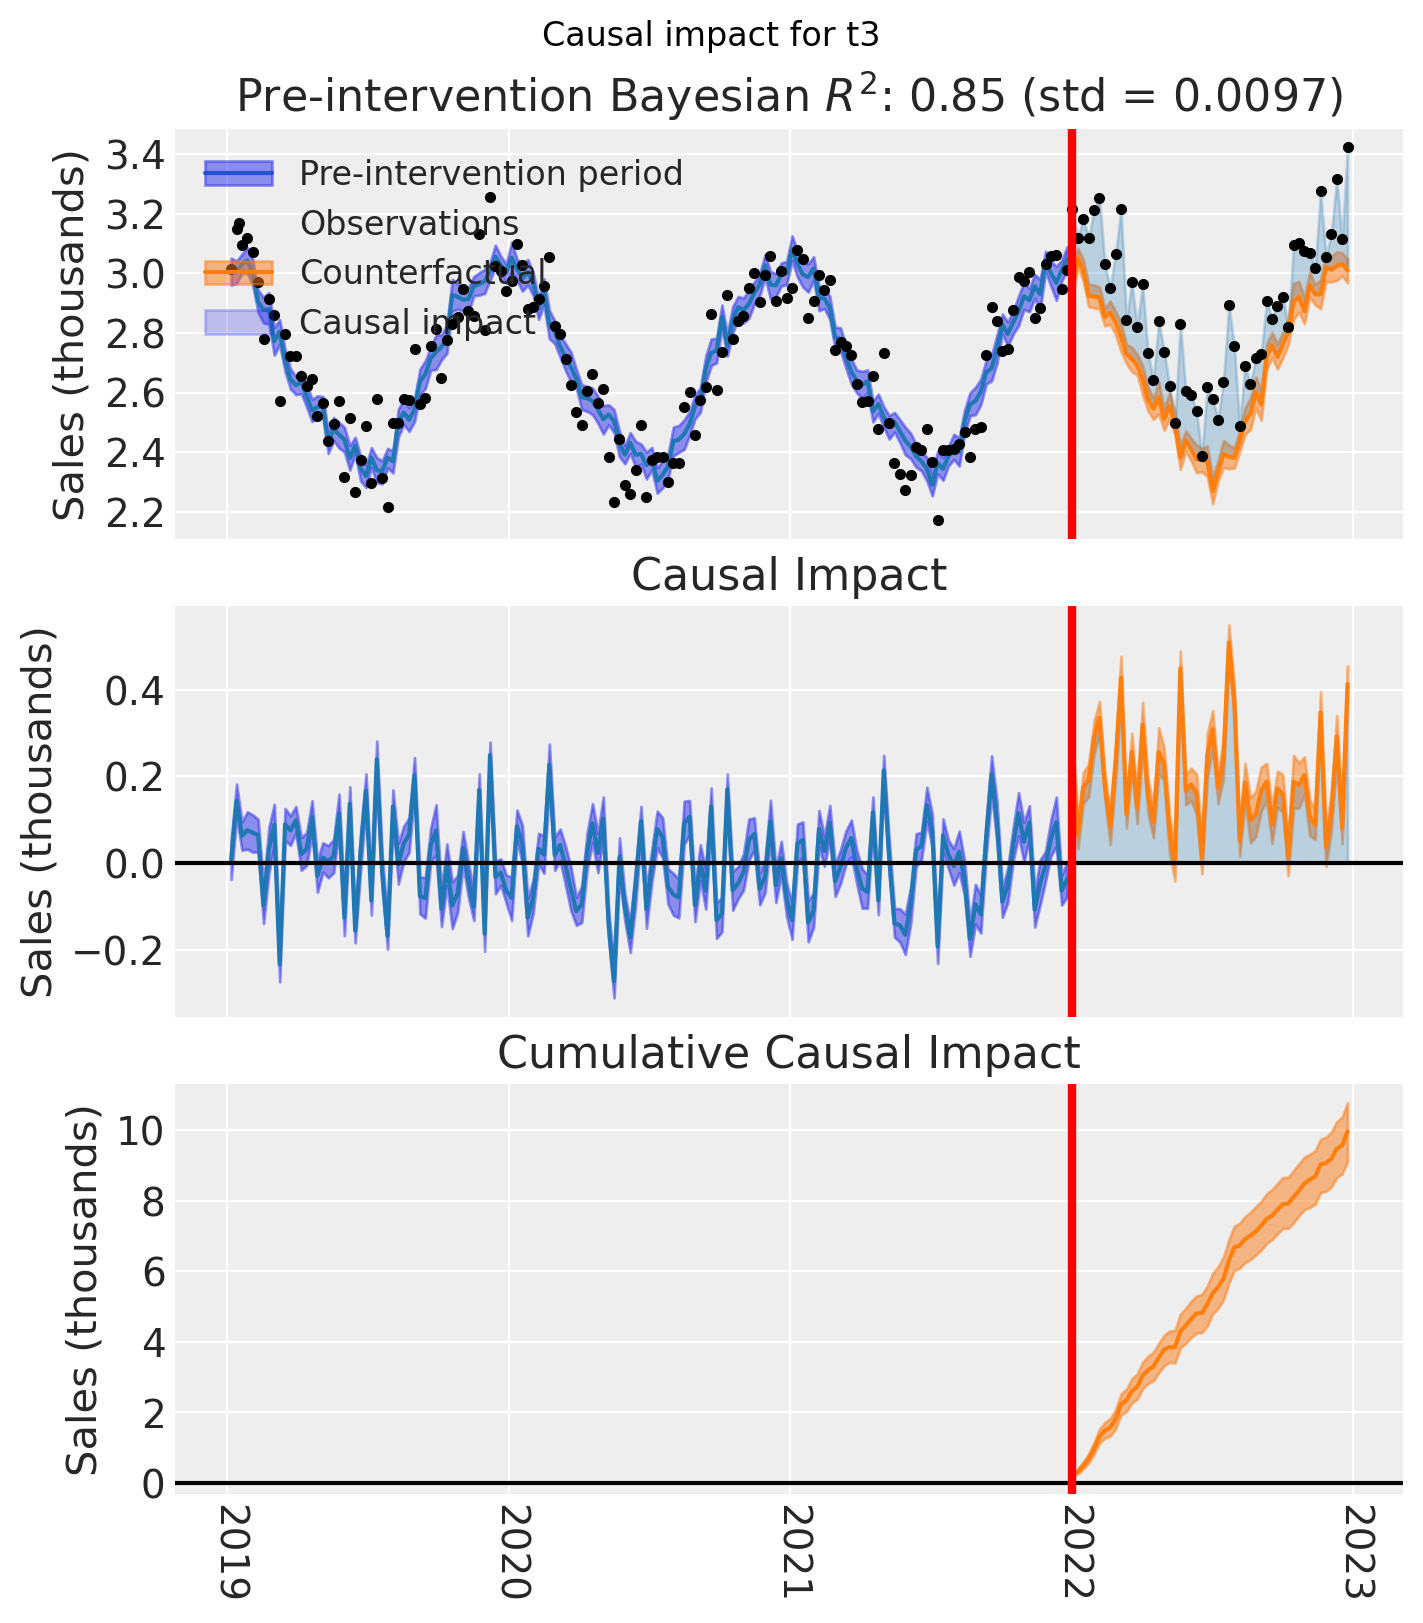

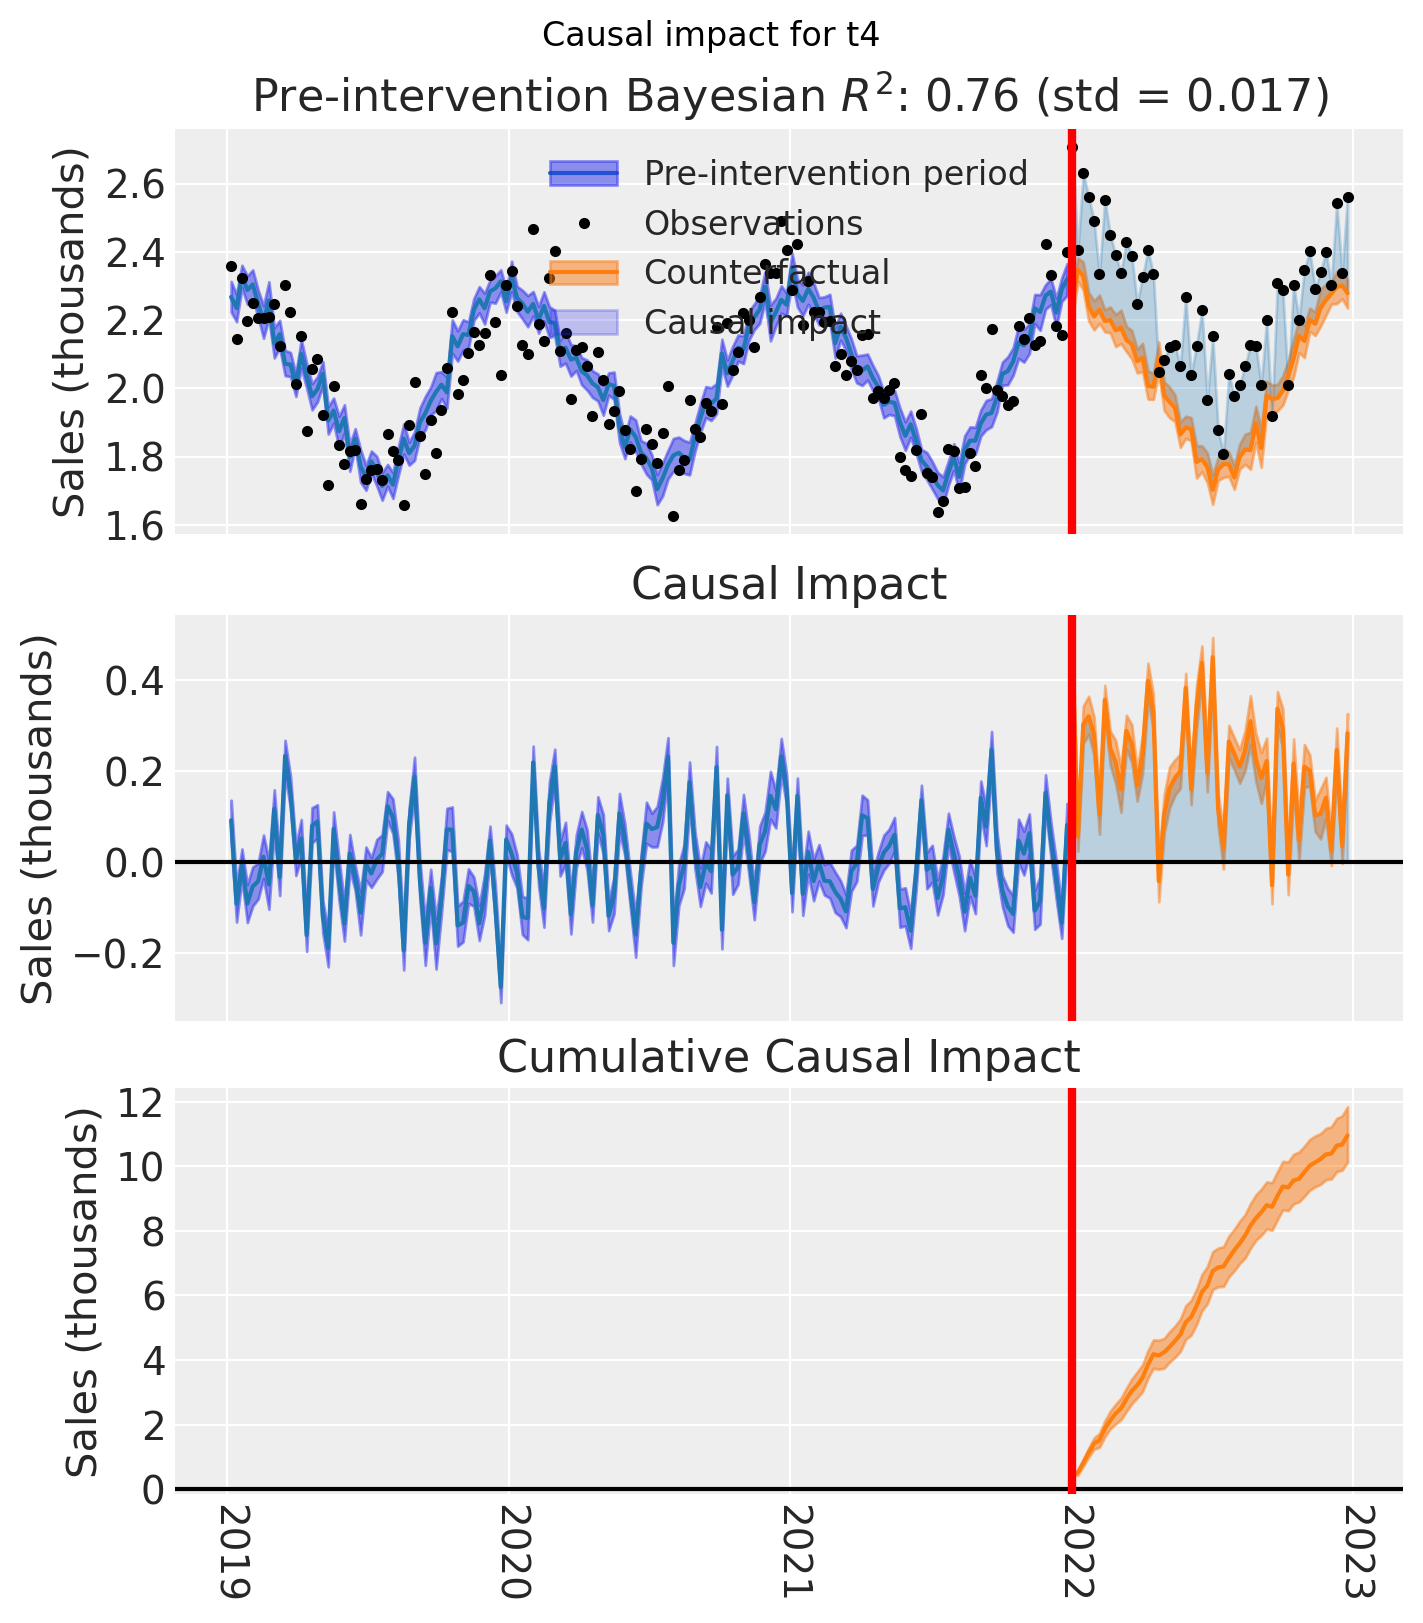

In [18]:
for t in treated:
    fig, ax = result_unpooled.plot(treated_unit=t)

    # formatting
    ax[2].tick_params(axis="x", labelrotation=-90)
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    for i in [0, 1, 2]:
        ax[i].set(ylabel="Sales (thousands)")
    plt.suptitle(f"Causal impact for {t}")

We've seen in this section that it is not just possible, but very easy to analyse geo lift result data when there are multiple treated geos. This approach essentially just iterates through each treated geo and analyses them individually.

This does of course mean that if we have a large number of treated geos, we will have a large number of results and plots to look at, but this is fine. 

## Comparing the two approaches

Let's compare the two approaches by plotting the posterior distribution of the total cumulative causal impact over the whole post=treatment period. 

The top plot shows the estimate for the pooled model, and the bottom shows the estimates for each of the models applied to the 4 treated geos.

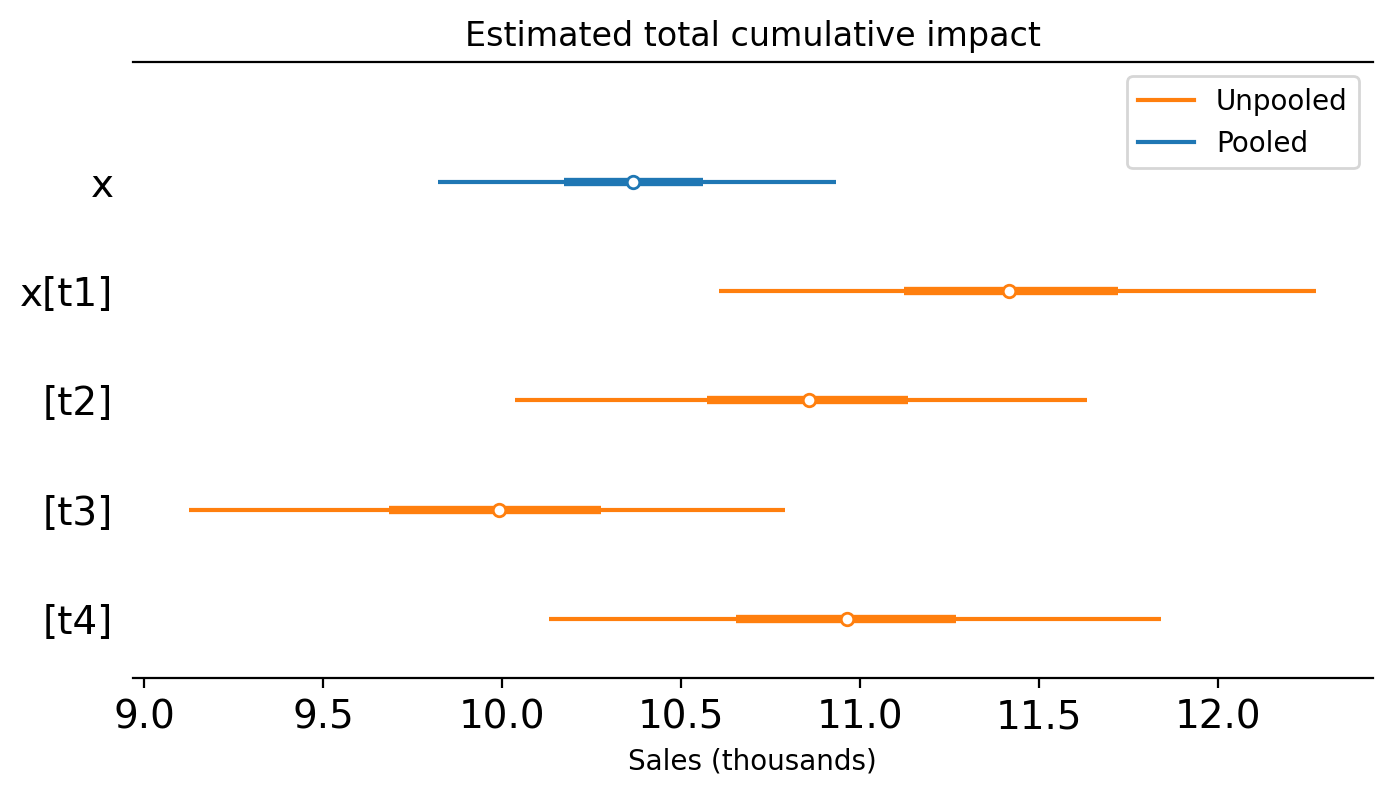

In [19]:
final_time_point = pooled.post_impact_cumulative.obs_ind.max()

pooled_cumulative = pooled.post_impact_cumulative.isel(treated_units=0).sel(
    obs_ind=final_time_point
)

unpooled_cumulative = result_unpooled.post_impact_cumulative.sel(
    obs_ind=final_time_point
)

axes = az.plot_forest(
    [pooled_cumulative, unpooled_cumulative],
    model_names=["Pooled", "Unpooled"],
    combined=True,
    figsize=(8, 4),
)
axes[0].set(title="Estimated total cumulative impact", xlabel="Sales (thousands)");

For this particular (simulated) dataset, the pooled and unpooled approaches give similar results. This is expected because the treatment was the same in each geo, and the causal impact of the treatment was similar in each geo. We'd likely see more variation in the estimates of the unpooled models if the real causal impacts were more heterogeneous across the geos.

## Using Results for MMM Calibration

If you're using geo-lift experiments to calibrate a Media Mix Model (MMM), you'll need to extract the lift estimates in a specific format. CausalPy provides the `extract_lift_for_mmm()` helper function to format your Synthetic Control results for use with [PyMC-Marketing's `add_lift_test_measurements()` method](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_lift_test.html).

PyMC-Marketing's lift test calibration expects a DataFrame with the following columns:

| Column | Description |
|--------|-------------|
| `channel` | The marketing channel tested |
| `geo` | The geographic unit identifier (must match your MMM's geo dimension) |
| `x` | Pre-test spend level for the channel |
| `delta_x` | Spend increase during the test period |
| `delta_y` | Estimated causal lift (posterior mean) |
| `sigma` | Uncertainty in the lift estimate (posterior std) |

The `extract_lift_for_mmm()` function handles extracting these values from your fitted Synthetic Control model, including proper uncertainty quantification from the Bayesian posterior.

In [ ]:
# Extract lift results from the unpooled model for MMM calibration
df_lift = cp.extract_lift_for_mmm(
    result_unpooled,
    channel="tv_campaign",  # Name of the channel being tested
    x=0.0,  # Pre-test spend (0 if this was a new channel activation)
    delta_x=10000,  # Spend during the test period
    aggregate="mean",  # Average lift per time period
)

df_lift

This DataFrame is now ready to be used with PyMC-Marketing to calibrate your MMM's saturation curves:

```python
# In PyMC-Marketing (not run here as it requires pymc-marketing package):
# mmm.add_lift_test_measurements(df_lift)
```

:::{note}
The `aggregate` parameter controls how the lift is summarized across post-intervention time periods:
- `"mean"`: Average lift per time period. Use this when your MMM operates at the same time granularity as the experiment (e.g., weekly MMM with weekly experiment data).
- `"sum"`: Total cumulative lift across all periods. Use this when you want to report the total campaign impact.
:::

For the full MMM calibration workflow, see the [PyMC-Marketing lift test documentation](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_lift_test.html).

## Summary

We've shown two methods that we can use to analyse geo lift data with multiple treated geos. To do this, we used a simulated dataset with seasonality and observation noise.

The first method is to aggregate the treated geos and analyze them as a single aggregated geo. This is useful when we expect the effects of the intervention to be similar in each treated region - for example if we deployed the same kind and magnitude of intervention in across the treated regions. This method is also useful when we have a large number of treated geos and we want to reduce the complexity of the modeling approach and create a single 'story' for the causal effects of the treatment across all treated geos.

The second method is to model all the treated geos in one model - we did this by giving the `SyntheticControl` class a list of treated geos. Currently, this is an unpooled model which will give equivalent results to running totally separate analyses of each treated region one at a time. This approach is useful when we want to understand the impact of each geo separately. This may make most sense if the treatments were different in kind or magnitude. That is, when we do not expect the effects of the intervention to be similar in each treated region.

But what about more a more complex scenario? We could imagine a situation where one intervention (e.g. a store refurbishment programme) was deployed in some geos, and a different intervention (e.g. a marketing campaign) was deployed in different geos. In this case, we could use a combination of the two methods we've shown here. We could aggregate the treated geos where the same intervention was deployed, and analyze the treated geos where different interventions were deployed separately.

Finally, we demonstrated how to extract the lift estimates in a format suitable for Media Mix Model (MMM) calibration using the `extract_lift_for_mmm()` helper function. This bridges the gap between CausalPy's geo-lift experiments and downstream MMM workflows in [PyMC-Marketing](https://github.com/pymc-labs/pymc-marketing).
